In [154]:
import os
os.chdir('/home/evlasova/covid-t-cell-classifier')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from multipy.fwer import sidak, hochberg
from xgboost import XGBClassifier
import random

from source.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, plot_waterfall_by_column, \
                            plot_feature_importances, plot_volcano, plot_clonotype_clustering_with_epitope_labeling
from source.usage_matrix_preprocessing import prepare_usage_matrix
from source.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from source.data_utils import prepare_run_column
from source.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from source.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence
from source.weblogo_utils import create_web_logo


import warnings
warnings.filterwarnings('ignore')


import importlib
imported_module = importlib.import_module("source.viz_utils")
importlib.reload(imported_module)

<module 'source.viz_utils' from '/home/evlasova/covid-t-cell-classifier/source/viz_utils.py'>

# Reading UMs

In [2]:
norm_um_joint = pd.read_csv('data/normalized_usage_matrix_joint_new.csv').drop(columns=['Unnamed: 0']).fillna(0)
stand_um_joint = pd.read_csv('data/standardized_log_exp_usage_matrix_joint_new.csv').drop(columns=['Unnamed: 0']).fillna(0)

In [3]:
norm_um_joint['project'] = norm_um_joint['project'].apply(lambda x: x.replace('_DNA', '').split('_')[-1])

In [4]:
stand_um_joint['project'] = stand_um_joint['project'].apply(lambda x: x.replace('_DNA', '').split('_')[-1])

In [5]:
stand_um_joint.platform.value_counts()

adaptive    2200
fmba        1240
Name: platform, dtype: int64

# Analysis of Adaptive found biomarkers

In [6]:
pvals = pd.read_csv(f'data/adaptive_clone_results/covid_pvals_all_hla_top_500k_1_mismatch_fisher.csv').drop(columns=['Unnamed: 0'])
fold_change_data = pd.read_csv('data/adaptive_clone_results/fold_change_data.csv')

In [7]:
fold_change_data['logp'] = fold_change_data.pval.apply(lambda x: np.log2(x + 1e-10))

In [10]:
np.random.seed(42)
x = np.random.uniform(low=0, high=1e-50, size=1)[0]
x

3.745401188473625e-51

In [26]:
chosen_clones = fold_change_data[(fold_change_data.log_fold_change > 2.5) & (fold_change_data.pval < x)]
chosen_clones

,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change,logp,selected clone
8389,CASSYSGLAGVYNEQFF,3.399224e-151,96,828,8.625000,3.108524,-33.219281,True
29352,CASSYSRTGGGYGYTF,4.549486e-156,38,702,18.473684,4.207400,-33.219281,True
58959,CASSYSGLAGIYNEQFF,9.731013e-134,64,755,11.796875,3.560333,-33.219281,True
60551,CASSQGNRANTEAFF,3.345272e-61,82,513,6.256098,2.645263,-33.219281,True
68972,CASSYSRTGGNYGYTF,4.284595e-152,43,733,17.046512,4.091405,-33.219281,True
...,...,...,...,...,...,...,...,...
498506,CASSQDPQGGYGYTF,4.632768e-64,116,670,5.775862,2.530036,-33.219281,True
498854,CASSYSGQGPYGYTF,6.264504e-132,103,827,8.029126,3.005243,-33.219281,True
498855,CASSYSRQGNEKLFF,4.631512e-70,64,583,9.109375,3.187352,-33.219281,True
498959,CASSYSSTGNYGYTF,1.094650e-86,89,688,7.730337,2.950531,-33.219281,True


Preparing data/adaptive_clone_results/sign_clone_matrix_fold_change.csv


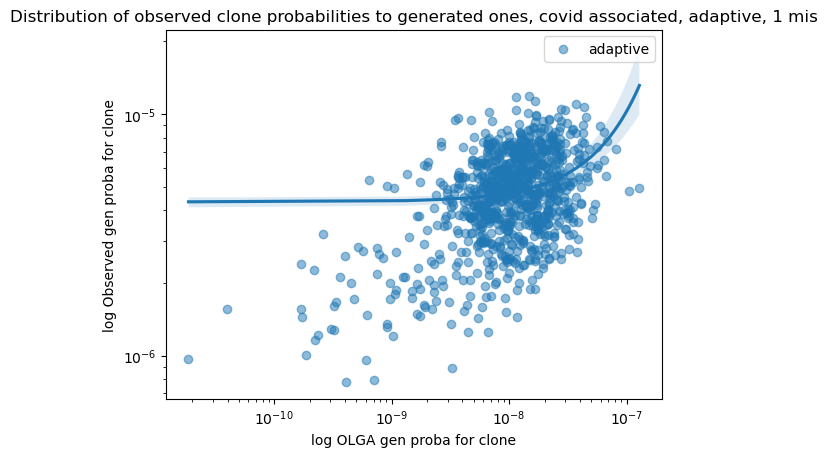

In [22]:
probas_adaptive = plot_generated_to_real_distribution(pgen_paths=['data/olga_pgen/adaptive_pgen.tsv'], 
                                    cm_paths=['data/adaptive_clone_results/sign_clone_matrix_fold_change.csv'], 
                                    desc='covid associated, adaptive, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clonotypes_adaptive.csv', 
                                    labels=['adaptive'],
                                    make_bool_features=False)['adaptive']

In [30]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [ ]:
res_adaptive = seqs2hamming(chosen_clones.clone, threshold=1, viz_method='graphopt')

In [41]:
res_adaptive

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CASSYSGLAGVYNEQFF,0,-403.908120,57.263123,9,-410.777986,54.964524
1,CASSYSGLAGIYNEQFF,0,-422.494306,49.283451,9,-410.777986,54.964524
2,CASSYSPLAGVYNEQFF,0,-389.266732,33.483055,9,-410.777986,54.964524
3,CASSYSGLAGAYNEQFF,0,-435.610692,62.531717,9,-410.777986,54.964524
4,CASSYSGLAGSYNEQFF,0,-411.043241,76.268295,9,-410.777986,54.964524
...,...,...,...,...,...,...,...
726,CASSQDASGGYEQYF,130,-710.399228,107.952315,1,-710.399228,107.952315
727,CASSQDFRGYEQYF,131,-690.602261,-87.244451,1,-690.602261,-87.244451
728,CASSQDLSGGTDTQYF,132,373.698494,610.533492,1,373.698494,610.533492
729,CASSQDPHTGELFF,133,-645.381350,50.477643,1,-645.381350,50.477643


In [45]:
adaptive_cluster_to_epi = {}
for cluster_index in range(135):
    adaptive_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_adaptive, cluster_index, dist=1, gene='TRB')

# Making FMBA based classifier

In [82]:
fmba_not_nan_hla = pd.read_csv('data/desc_fmba_not_nan_hla.csv')

In [86]:
fmba_not_nan_hla = fmba_not_nan_hla[fmba_not_nan_hla.COVID_status != 'unknown']

In [88]:
good_fmba_samples = fmba_not_nan_hla.run

In [89]:
good_fmba_samples

0        020000010808_S3_L001.clonotypes.TRB.txt
1       020000110808_S14_L001.clonotypes.TRB.txt
2       020000190808_S27_L001.clonotypes.TRB.txt
3      020000200808_S181_L002.clonotypes.TRB.txt
4       020000280808_S59_L001.clonotypes.TRB.txt
                         ...                    
963    780008510808_S152_L002.clonotypes.TRB.txt
964    780008550808_S150_L002.clonotypes.TRB.txt
965    910000140808_S123_L002.clonotypes.TRB.txt
966    910000320808_S121_L002.clonotypes.TRB.txt
967    910003810808_S120_L002.clonotypes.TRB.txt
Name: run, Length: 956, dtype: object

In [107]:
data_fmba = prepare_data(run_to_number_of_clones_path = 'data/run_to_number_of_clonotypes.csv',
                 desc_path='data/standardized_log_exp_usage_matrix_joint_new.csv',
                 clonotype_matrix_path='data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_fmba_adaptive.csv',
                 hla_keys_path=None,
                 make_freq=True,
                 use_hla_clones=False,
                 use_hla_bool=False,
                 make_all_features_bool=True,
                 use_standardization=True,
                 raw_target_column='covid',
                 raw_target_clumn_success_label='covid',
                 final_target_column='covid')
fmba_good_beta_biomarkers_data = [x for x in pd.read_csv('data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_wo_leaks_diagonal.csv').columns if x.startswith('CAS')]
data_fmba = data_fmba[fmba_good_beta_biomarkers_data + ['covid']]
data_fmba['folder'] = stand_um_joint['project']
data_fmba['platform'] = stand_um_joint['platform']
data_fmba['run'] = stand_um_joint['run']

In [108]:
data_fmba = data_fmba[(data_fmba.run.isin(good_fmba_samples)) | (data_fmba.platform == 'adaptive')].drop(columns=['run', 'platform'])

In [109]:
data_fmba

,CASSLGYEQYF,CASSLGGNQPQHF,CASSLGSNQPQHF,CASSLTGNTEAFF,CASSSSYEQYF,CASSLGGYEQYF,CASSLDRNTEAFF,CASSLSYEQYF,CASSLAGNTEAFF,CASSPSYEQYF,...,CASSMSYEQYF,CASSRGTEQYF,CASSMAYEQYF,CASSQKGYEQYF,CASSMDRGYEQYF,CASRRTYEQYF,CASSRGWEQYF,CASSQWYEQYF,covid,folder
0,-2.051336,-2.550600,2.436834,-0.355232,0.680345,1.658236,7.891120,-0.816740,1.533409,1.141865,...,0.160558,-0.823143,5.470818,-0.866269,-1.077628,-0.757114,-0.786515,6.437477,1,NovaSeq5
1,0.070584,0.021766,0.105894,-0.333066,2.708344,-0.876576,-1.070796,1.597721,-1.061951,1.943291,...,2.476003,-0.823143,2.967504,-0.866269,-1.077628,-0.757114,-0.786515,1.745408,1,NovaSeq5
2,0.478214,1.392082,0.562534,1.809401,0.821261,-0.629508,-0.429899,1.932058,0.760821,0.844912,...,0.531487,-0.823143,1.747994,0.516398,-1.077628,2.695839,-0.786515,1.158435,0,NovaSeq5
3,0.458498,-1.536391,-0.084351,-0.253141,0.799558,0.499464,2.843070,-0.348618,2.164118,-1.914226,...,-1.659719,2.801072,-1.315428,2.334808,-1.077628,-0.757114,3.011295,-1.114197,1,NovaSeq5
4,2.029295,-0.901641,1.284268,-1.978032,1.031371,0.001451,-1.344925,-0.658760,-2.378783,0.682190,...,0.402259,-0.823143,-1.315428,-0.866269,-1.077628,-0.757114,2.300833,-1.114197,1,NovaSeq5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3434,0.180497,0.193119,0.275973,-0.870812,0.389727,0.437985,-0.767513,0.080285,-0.774279,0.405882,...,0.246362,0.266247,0.283453,-0.385169,-0.173150,0.143979,0.069663,-0.323433,0,KECK
3435,-0.431340,-0.276619,-0.766796,-1.212561,0.289313,0.369559,-0.985756,0.232251,-0.943520,0.527066,...,0.408318,0.100258,-0.592622,0.764914,0.455699,0.057601,0.181116,-0.309865,0,KECK
3436,0.236411,-0.853447,-0.887740,-1.395985,0.555085,0.227681,-1.137457,0.091109,-1.451712,0.432184,...,0.307238,0.212289,0.324869,-0.343674,-0.217950,0.058564,0.608521,-0.040487,0,KECK
3437,0.425121,0.671237,0.689132,-0.056843,0.596593,1.168799,-0.208265,0.387403,0.245112,0.891316,...,0.812510,0.223497,0.135367,-0.519604,-0.100022,0.541484,0.310257,-0.069565,0,KECK


In [110]:
X_train_fmba, y_train_fmba, X_test_fmba, y_test_fmba = split_data_by_batch(data=data_fmba, 
                                                       test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' not in x], 
                                                       y_column='covid', 
                                                       batch_column='folder')

In [111]:
fmba_clf = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_fmba, y_train_fmba)

In [112]:
y_pred_fmba = fmba_clf.predict(X_test_fmba)

In [113]:
metrics_fmba = pd.DataFrame({'f1': [round(f1_score(y_test_fmba, y_pred_fmba), 2)], 
              'precision': [round(precision_score(y_test_fmba, y_pred_fmba), 2)], 
              'recall': [round(recall_score(y_test_fmba, y_pred_fmba), 2)]})

# Making Adaptive based classifier

In [115]:
data_adaptive = prepare_data(run_to_number_of_clones_path='data/run_to_number_of_clonotypes.csv',
             desc_path='data/standardized_log_exp_usage_matrix_joint_new.csv',
             clonotype_matrix_path='data/adaptive_clone_results/sign_clone_matrix_fold_change_wo_leaks_diagonal.csv',
             hla_keys_path=None,
             make_freq=True,
             use_hla_clones=False,
             use_hla_bool=False,
             make_all_features_bool=True,
             use_standardization=True,
             raw_target_column='covid',
             raw_target_clumn_success_label='covid',
             final_target_column='covid')

data_adaptive['folder'] = stand_um_joint['project']
data_adaptive['platform'] = stand_um_joint['platform']
data_adaptive['run'] = stand_um_joint['run']

In [116]:
data_adaptive = data_adaptive[(data_adaptive.run.isin(good_fmba_samples)) | (data_adaptive.platform == 'adaptive')].drop(columns=['run', 'platform'])

In [117]:
X_train_adaptive, y_train_adaptive, X_test_adaptive, y_test_adaptive = split_data_by_batch(data=data_adaptive, 
                                                                           test_batches=[x for x in stand_um_joint.project.unique() if 'Nova' in x], 
                                                                           y_column='covid', 
                                                                           batch_column='folder')

In [118]:
adaptive_clf = SVC(C=5, kernel='rbf', probability=True, random_state=42).fit(X_train_adaptive, y_train_adaptive)

In [119]:
y_pred_adaptive = adaptive_clf.predict(X_test_adaptive)

In [120]:
metrics_adaptive = pd.DataFrame({'f1': [round(f1_score(y_test_adaptive, y_pred_adaptive), 2)], 
              'precision': [round(precision_score(y_test_adaptive, y_pred_adaptive), 2)], 
              'recall': [round(recall_score(y_test_adaptive, y_pred_adaptive), 2)]})

# Making joint df for metrics

In [121]:
y_test_data = {
    'fmba': y_test_fmba,
    'adaptive': y_test_adaptive
} 
all_clfs = {
    'fmba': fmba_clf,
    'adaptive': adaptive_clf
} 
X_test_data = {
    'fmba': X_test_fmba,
    'adaptive': X_test_adaptive
} 

In [122]:
metrics = pd.concat([metrics_fmba, metrics_adaptive])
metrics.index = ['fmba', 'adaptive']

In [123]:
metrics

,f1,precision,recall
fmba,0.79,0.67,0.95
adaptive,0.82,0.69,1.00


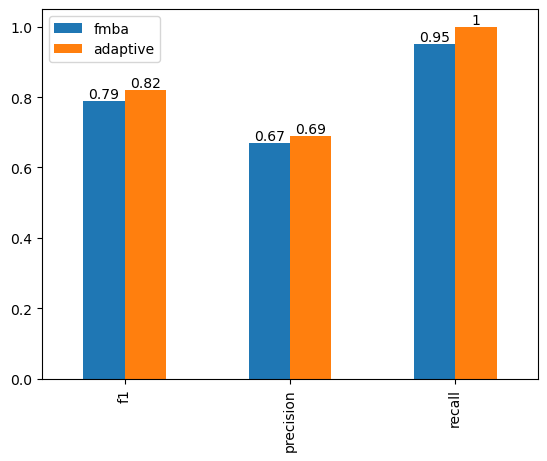

In [131]:
fig, ax = plt.subplots()
metrics.T.plot.bar(ax=ax)
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

# Making joint clustering results

In [133]:
covid_clones_fmba_beta = pd.read_csv(
    'data/hla_sign_clone_matrix/covid_clonotype_matrix_500k_top_1_mismatch_hla_all_fisher_wo_leaks_diagonal.csv').drop(
    columns=['Unnamed: 0']).columns[:-1]

In [163]:
res_joint = seqs2hamming(list(chosen_clones.clone) + list(covid_clones_fmba_beta), threshold=1, viz_method='graphopt')

In [164]:
res_joint['platform'] = res_joint.cdr3.apply(lambda x: 'fmba' if x in covid_clones_fmba_beta else 'adaptive')

In [165]:
res_joint

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean,platform
0,CASSYSGLAGVYNEQFF,0,266.968179,-266.136804,9,260.949589,-269.994912,adaptive
1,CASSYSGLAGIYNEQFF,0,249.341971,-275.507324,9,260.949589,-269.994912,adaptive
2,CASSYSPLAGVYNEQFF,0,257.436229,-239.890853,9,260.949589,-269.994912,adaptive
3,CASSYSGLAGAYNEQFF,0,277.206330,-283.370732,9,260.949589,-269.994912,adaptive
4,CASSYSGLAGSYNEQFF,0,268.267928,-297.993949,9,260.949589,-269.994912,adaptive
...,...,...,...,...,...,...,...,...
1036,CASSQGRNSPLHF,152,-284.949871,730.145699,1,-284.949871,730.145699,fmba
1037,CASSLGGGGEQYF,153,670.252104,269.941285,1,670.252104,269.941285,fmba
1038,CASSQGLGQPQHF,154,-318.195322,578.548095,1,-318.195322,578.548095,fmba
1039,CASSRGQDTEAFF,155,465.740791,632.231857,1,465.740791,632.231857,fmba


In [166]:
joint_cluster_to_epi = {}
for cluster_index in range(157):
    joint_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_joint, cluster_index, dist=1, gene='TRB')

(-900.0, 900.0)

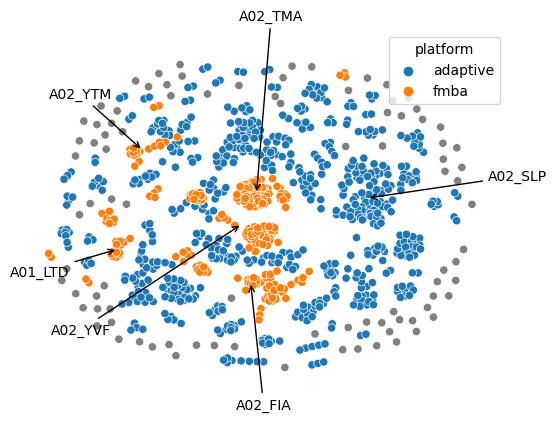

In [170]:
fig, ax = plt.subplots()
plot_clonotype_clustering_with_epitope_labeling(res_joint, 
                                                joint_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB',
                                                color_by='platform',
                                                cluster_size_threshold=0, 
                                                dist_to_center=850, 
                                                center_diff_threshold=75,
                                                ax=ax)
ax.set_xlim(-900, 900)
ax.set_ylim(-900, 900)


# Plotting Fig 5

In [ ]:
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(nrows=3, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.14

########################################################
ax0 = fig.add_subplot(gs[0, :3])

plot_usage_matrix_pca(norm_um_joint, method=PCA, target='project', ax=ax0)

ax0.legend()
ax0.set_title('PCA for FMBA/Adaptive data before Batch effect fixing')
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)
ax0.legend([],[], frameon=False)

########################################################
ax1 = fig.add_subplot(gs[0, 3:])

plot_usage_matrix_pca(stand_um_joint, method=PCA, target='project', ax=ax1)

ax1.legend()
ax1.set_title('PCA for FMBA/Adaptive data after Batch effect fixing')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)
handles, labels = ax1.get_legend_handles_labels()
pairs = [(x, y) for x, y in zip(handles, labels)]
pairs.sort(key=lambda x: x[1])

leg = ax1.legend([x[0] for x in pairs],[x[1] for x in pairs], ncol=2, bbox_to_anchor=(1.01, 0.9)) 

# sns.move_legend(ax1, "upper right", bbox_to_anchor=(1.15, 1.1))
########################################################

ax3 = fig.add_subplot(gs[1, :2])
plot_volcano(fold_change_data, x, 2.5, ax=ax3)
ax3.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)
ax3.set_ylabel('log p-value')

########################################################

ax4 = fig.add_subplot(gs[1, 2:4])
plot_olga_cleanup_data(probas_adaptive, observed_threshold=2.5e-6, gen_threshold=2e-9, ax=ax4)
ax4.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

########################################################

ax5 = fig.add_subplot(gs[1, 4:])


plot_clonotype_clustering_with_epitope_labeling(res_adaptive, 
                                                adaptive_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=650, 
                                                center_diff_threshold=75,
                                                ax=ax5)
ax5.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.set_xlim(-800, 800)
ax5.set_ylim(-800, 800)
ax5.set_title('Adaptive TCRβ clone clustering')
ax5.legend([],[], frameon=False)

########################################################

ax6 = fig.add_subplot(gs[2, :2])

for key in ['fmba', 'adaptive']:
    fpr, tpr, _ = roc_curve(y_test_data[key], all_clfs[key].predict_proba(X_test_data[key])[::,1])
    ax6.plot(fpr,tpr, label=key)

ax6.set_ylabel('True Positive Rate')
ax6.set_xlabel('False Positive Rate')
ax6.plot([0, 1], [0, 1], linestyle='dashed', color='grey')
ax6.legend()
ax6.set_title('ROC-curve')
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)


########################################################

ax2 = fig.add_subplot(gs[2, 2:4])

metrics.T.plot.bar(ax=ax2)
for c in ax.containers:
    ax2.bar_label(c, label_type='edge')
ax2.set_ylim(0, 1.2)
ax2.tick_params(labelrotation=20)
ax2.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)
########################################################

ax5 = fig.add_subplot(gs[2, 4:])
plot_clonotype_clustering_with_epitope_labeling(res_joint, 
                                                joint_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRB',
                                                color_by='platform',
                                                cluster_size_threshold=0, 
                                                dist_to_center=850, 
                                                center_diff_threshold=75,
                                                ax=ax5)
ax5.set_xlim(-900, 900)
ax5.set_ylim(-900, 1000)
ax5.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.set_title('Adaptive/FMBA TCRβ clone clustering')

########################################################

plt.tight_layout()
plt.savefig("figures/fig5.svg")
plt.savefig("figures/fig5.pdf")
plt.savefig("figures/fig5.pdf")
plt.show()
